## 4.5　自動特徴量選択

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

特徴量の選択には、**単変量統計**と**モデルベース選択**と**反復選択**の3つがある。

### 4.5.1　単変量統計（SelectPercentile）

単変量統計では、個々の特徴量とターゲットとの間に統計的な関係があるかを計算する。これには分散分析を使用する。<br>
個々の特徴量を考慮することはできるが、他の特徴量と組み合わさって意味を持つような特徴量は捨てられてしまう。

単変量特徴量選択をsklearnで行うには、テストを選択する必要があり、分類はf_classif、回帰はf_regressionがデフォルトである。<br>
テストで求めたp-値をもとに、特徴量を捨てる方法（p-値が大きすぎる特徴量を捨てる際のしきい値）を指定する。

実際の例で、情報量のない特徴量（ノイズ）を加えて、特徴量選択がこれを検出して排除してくれるかどうかを確認する。

In [2]:
cancer = load_breast_cancer()

rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))

X_w_noise = np.hstack([cancer.data, noise])

print(cancer.data.shape)
print(noise.shape)
print(X_w_noise.shape)

(569, 30)
(569, 50)
(569, 80)


test_sizeを.5（0.5）で指定すると、5割がテストデータになる。

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X_w_noise, cancer.target, random_state=0, test_size=0.5)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(284, 80)
(284,)
(285, 80)
(285,)


f_classifとSelectPercentileを使って、50%の特徴量を選択する。

In [4]:
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)

X_train_selected = select.transform(X_train)

print(X_train.shape)
print(X_train_selected.shape)

(284, 80)
(284, 40)


どの特徴量が使われているのかを、get_supportメソッドで調べることができる。

In [5]:
mask = select.get_support()
print(mask[:10])

[ True  True  True  True  True  True  True  True  True False]


マスクを可視化する。

Text(0.5, 0, 'Sample index')

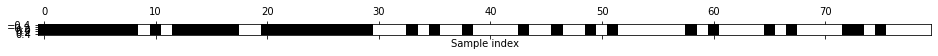

In [6]:
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel('Sample index')

最初の30個の特徴量はデータセットのもので、あとの50個の特徴量はノイズであるため<br>
しっかり判別されていることが分かる。

In [7]:
X_test_selected = select.transform(X_test)

lr = LogisticRegression()

In [8]:
lr.fit(X_train, y_train)

print('Score with all features: {:.3f}'.format(lr.score(X_test, y_test)))

Score with all features: 0.919


C:\Users\Owner\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [9]:
lr.fit(X_train_selected, y_train)

print('Score with only selected features: {:.3f}'.format(lr.score(X_test_selected, y_test)))

Score with only selected features: 0.916


C:\Users\Owner\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


今回の場合は、単変量特徴量選択をしても精度は向上していないが<br>
実際には有効になるケースもあるので、ぜひ活用していきたい。

### 4.5.2　モデルベース特徴量選択（SelectFromModel）

単変量特徴量選択とは対照的に、モデルベースの選択は<br>
すべての特徴量を同時に考慮するので、交互作用を捉えることができる。

In [12]:
select = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median')

スレッショルド：しきい値

SelectFromModelクラスは、特徴量の重要性がしきい値（今回は中央値）を超えたものだけを選択する。

In [13]:
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)

print('X_train.shape: {}'.format(X_train.shape))
print('X_train_l1.shape: {}'.format(X_train_l1.shape))

X_train.shape: (284, 80)
X_train_l1.shape: (284, 40)


選択した特徴量を見る。黒が真（選択されている）、白が偽（選択されていない）である。

In [15]:
mask = select.get_support()
print(mask[:10])

[ True  True  True  True  True  True  True  True  True  True]


Text(0.5, 0, 'Sample index')

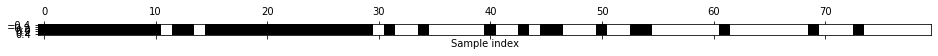

In [16]:
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel('Sample index')

In [18]:
X_test_l1 = select.transform(X_test)

score = LogisticRegression().fit(X_train_l1, y_train).score(X_test_l1, y_test)
print('Test score: {:.3f}'.format(score))

Test score: 0.930


C:\Users\Owner\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
